<a href="https://colab.research.google.com/github/a7medmo7amady/AI-project-/blob/main/ai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# vars

In [ ]:
EMPTY = 0
PLAYER1 = 1
PLAYER2 = 2

ROWS = 6
COLS = 7

nodes_explored = 0
nodes_pruned = 0

In [ ]:
def create_board():
    return np.zeros((ROWS, COLS), dtype=int)

def copy_board(board):
    return np.copy(board)

def is_valid_move(board, col):
    return board[0][col] == EMPTY

def get_valid_moves(board):
    return [col for col in range(COLS) if is_valid_move(board, col)]

def get_next_open_row(board, col):
    for row in range(ROWS - 1, -1, -1):
        if board[row][col] == EMPTY:
            return row
    return None

def make_move(board, col, player):
    new_board = copy_board(board)
    row = get_next_open_row(new_board, col)
    if row is not None:
        new_board[row][col] = player
    return new_board

def check_winner(board):
    for row in range(ROWS):
        for col in range(COLS - 3):
            if board[row][col] != EMPTY and \
               board[row][col] == board[row][col+1] == board[row][col+2] == board[row][col+3]:
                return board[row][col]

    for row in range(ROWS - 3):
        for col in range(COLS):
            if board[row][col] != EMPTY and \
               board[row][col] == board[row+1][col] == board[row+2][col] == board[row+3][col]:
                return board[row][col]

    for row in range(ROWS - 3):
        for col in range(COLS - 3):
            if board[row][col] != EMPTY and \
               board[row][col] == board[row+1][col+1] == board[row+2][col+2] == board[row+3][col+3]:
                return board[row][col]

    for row in range(3, ROWS):
        for col in range(COLS - 3):
            if board[row][col] != EMPTY and \
               board[row][col] == board[row-1][col+1] == board[row-2][col+2] == board[row-3][col+3]:
                return board[row][col]

    return None

def is_terminal(board):
    return check_winner(board) is not None or len(get_valid_moves(board)) == 0

def display_board(board):
    print("\n  0 1 2 3 4 5 6")
    print("  " + "-" * 14)
    for row in range(ROWS):
        print(f"{row}|", end="")
        for col in range(COLS):
            piece = board[row][col]
            if piece == EMPTY:
                print("· ", end="")
            elif piece == PLAYER1:
                print("R ", end="")
            else:
                print("Y ", end="")
        print("|")
    print("  " + "-" * 14)

def visualize_board(board, title="Connect Four"):
    fig, ax = plt.subplots(figsize=(8, 7))

    ax.add_patch(plt.Rectangle((0, 0), COLS, ROWS, color='#0066CC', zorder=0))

    for row in range(ROWS):
        for col in range(COLS):
            circle = plt.Circle((col + 0.5, ROWS - row - 0.5), 0.4,
                              color='white', zorder=1)
            ax.add_patch(circle)

            piece = board[row][col]
            if piece == PLAYER1:
                piece_circle = plt.Circle((col + 0.5, ROWS - row - 0.5), 0.38,
                                        color='#DC143C', ec='darkred', linewidth=2, zorder=2)
                ax.add_patch(piece_circle)
            elif piece == PLAYER2:
                piece_circle = plt.Circle((col + 0.5, ROWS - row - 0.5), 0.38,
                                        color='#FFD700', ec='orange', linewidth=2, zorder=2)
                ax.add_patch(piece_circle)

    ax.set_xlim(0, COLS)
    ax.set_ylim(0, ROWS)
    ax.set_aspect('equal')
    ax.set_xticks(range(COLS + 1))
    ax.set_yticks(range(ROWS + 1))
    ax.set_xticklabels([str(i) for i in range(COLS)] + [''])
    ax.set_yticklabels([''] + [str(ROWS - i - 1) for i in range(ROWS)])
    ax.grid(False)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    for col in range(COLS):
        ax.text(col + 0.5, ROWS + 0.3, str(col), ha='center',
               fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_window(window, player):
    score = 0
    opponent = PLAYER2 if player == PLAYER1 else PLAYER1

    player_count = np.count_nonzero(window == player)
    opponent_count = np.count_nonzero(window == opponent)
    empty_count = np.count_nonzero(window == EMPTY)

    if player_count == 4:
        score += 100000
    elif player_count == 3 and empty_count == 1:
        score += 100
    elif player_count == 2 and empty_count == 2:
        score += 10

    if opponent_count == 3 and empty_count == 1:
        score -= 80
    elif opponent_count == 2 and empty_count == 2:
        score -= 5

    return score

def evaluate(board, player):
    score = 0

    winner = check_winner(board)
    if winner == player:
        return 100000
    elif winner is not None:
        return -100000

    center_col = COLS // 2
    center_count = np.count_nonzero(board[:, center_col] == player)
    score += center_count * 3

    for row in range(ROWS):
        for col in range(COLS - 3):
            window = board[row, col:col+4]
            score += evaluate_window(window, player)

    for row in range(ROWS - 3):
        for col in range(COLS):
            window = board[row:row+4, col]
            score += evaluate_window(window, player)

    for row in range(ROWS - 3):
        for col in range(COLS - 3):
            window = np.array([board[row+i][col+i] for i in range(4)])
            score += evaluate_window(window, player)

    for row in range(3, ROWS):
        for col in range(COLS - 3):
            window = np.array([board[row-i][col+i] for i in range(4)])
            score += evaluate_window(window, player)

    return score

In [ ]:
def minimax(board, depth, maximizing, player):
    global nodes_explored
    nodes_explored += 1

    valid_moves = get_valid_moves(board)
    is_term = is_terminal(board)

    if depth == 0 or is_term:
        if is_term:
            winner = check_winner(board)
            if winner == player:
                return (100000000, None)
            elif winner is not None:
                return (-100000000, None)
            else:
                return (0, None)
        else:
            return (evaluate(board, player), None)

    if maximizing:
        max_eval = float('-inf')
        best_col = valid_moves[0] if valid_moves else None

        for col in valid_moves:
            new_board = make_move(board, col, player)
            eval_score, _ = minimax(new_board, depth - 1, False, player)

            if eval_score > max_eval:
                max_eval = eval_score
                best_col = col

        return max_eval, best_col
    else:
        min_eval = float('inf')
        opponent = PLAYER2 if player == PLAYER1 else PLAYER1
        best_col = valid_moves[0] if valid_moves else None

        for col in valid_moves:
            new_board = make_move(board, col, opponent)
            eval_score, _ = minimax(new_board, depth - 1, True, player)

            if eval_score < min_eval:
                min_eval = eval_score
                best_col = col

        return min_eval, best_col

In [ ]:
def alphabeta(board, depth, alpha, beta, maximizing, player):
    global nodes_explored, nodes_pruned
    nodes_explored += 1

    valid_moves = get_valid_moves(board)
    is_term = is_terminal(board)

    if depth == 0 or is_term:
        if is_term:
            winner = check_winner(board)
            if winner == player:
                return (100000000, None)
            elif winner is not None:
                return (-100000000, None)
            else:
                return (0, None)
        else:
            return (evaluate(board, player), None)

    if maximizing:
        max_eval = float('-inf')
        best_col = valid_moves[0] if valid_moves else None

        for col in valid_moves:
            new_board = make_move(board, col, player)
            eval_score, _ = alphabeta(new_board, depth - 1, alpha, beta, False, player)

            if eval_score > max_eval:
                max_eval = eval_score
                best_col = col

            alpha = max(alpha, eval_score)
            if beta <= alpha:
                nodes_pruned += 1
                break

        return max_eval, best_col
    else:
        min_eval = float('inf')
        opponent = PLAYER2 if player == PLAYER1 else PLAYER1
        best_col = valid_moves[0] if valid_moves else None

        for col in valid_moves:
            new_board = make_move(board, col, opponent)
            eval_score, _ = alphabeta(new_board, depth - 1, alpha, beta, True, player)

            if eval_score < min_eval:
                min_eval = eval_score
                best_col = col

            beta = min(beta, eval_score)
            if beta <= alpha:
                nodes_pruned += 1
                break

        return min_eval, best_col

In [ ]:
def play_game(p1_depth=6, p2_depth=6, p1_algo="minimax", p2_algo="alphabeta",
              verbose=True, max_moves=42):
    board = create_board()
    current_player = PLAYER1
    move_count = 0

    metrics = {'PLAYER1': [], 'PLAYER2': []}

    if verbose:
        print("="*70)
        print(f"Game Start: {p1_algo.upper()} (RED) vs {p2_algo.upper()} (YELLOW)")
        print(f"Depths: RED={p1_depth}, YELLOW={p2_depth}")
        print("="*70)
        visualize_board(board, "Starting Position")

    while not is_terminal(board) and move_count < max_moves:
        global nodes_explored, nodes_pruned

        move_count += 1
        player_name = "PLAYER1" if current_player == PLAYER1 else "PLAYER2"
        algo = p1_algo if current_player == PLAYER1 else p2_algo
        depth = p1_depth if current_player == PLAYER1 else p2_depth

        if verbose:
            print(f"\nMove {move_count}: {player_name} ({algo}, depth={depth})")

        nodes_explored = 0
        nodes_pruned = 0
        start_time = time.time()

        if algo == "minimax":
            _, best_col = minimax(board, depth, True, current_player)
        else:
            _, best_col = alphabeta(board, depth, float('-inf'), float('inf'),
                                   True, current_player)

        time_taken = time.time() - start_time

        if best_col is None:
            if verbose:
                print(f"No valid moves for {player_name}")
            break

        metrics[player_name].append({
            'nodes': nodes_explored,
            'pruned': nodes_pruned,
            'time': time_taken,
            'move': best_col
        })

        if verbose:
            print(f"  Chose column: {best_col}")
            print(f"  Nodes explored: {nodes_explored}")
            if algo == "alphabeta":
                print(f"  Nodes pruned: {nodes_pruned}")
            print(f"  Time: {time_taken:.4f}s")

        board = make_move(board, best_col, current_player)

        if verbose:
            display_board(board)

        winner = check_winner(board)
        if winner:
            if verbose:
                print(f"\n{'='*70}")
                print(f"WINNER: {'PLAYER1 (RED)' if winner == PLAYER1 else 'PLAYER2 (YELLOW)'}")
                print(f"{'='*70}")
                visualize_board(board, f"Final - Winner: {'RED' if winner == PLAYER1 else 'YELLOW'}")
            return board, metrics, winner

        current_player = PLAYER2 if current_player == PLAYER1 else PLAYER1

    if verbose:
        print(f"\n{'='*70}")
        print("GAME OVER - DRAW")
        print(f"{'='*70}")
        visualize_board(board, "Final - Draw")

    return board, metrics, None

CONNECT FOUR AI - MINIMAX vs ALPHA-BETA

### INITIAL BOARD ###

  0 1 2 3 4 5 6
  --------------
0|· · · · · · · |
1|· · · · · · · |
2|· · · · · · · |
3|· · · · · · · |
4|· · · · · · · |
5|· · · · · · · |
  --------------


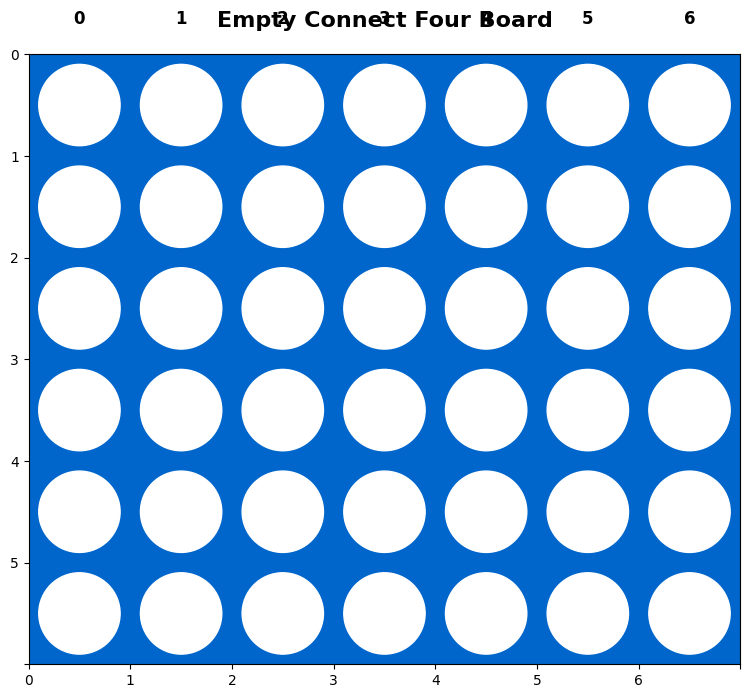


### SAMPLE GAME ###
Game Start: MINIMAX (RED) vs ALPHABETA (YELLOW)
Depths: RED=5, YELLOW=5


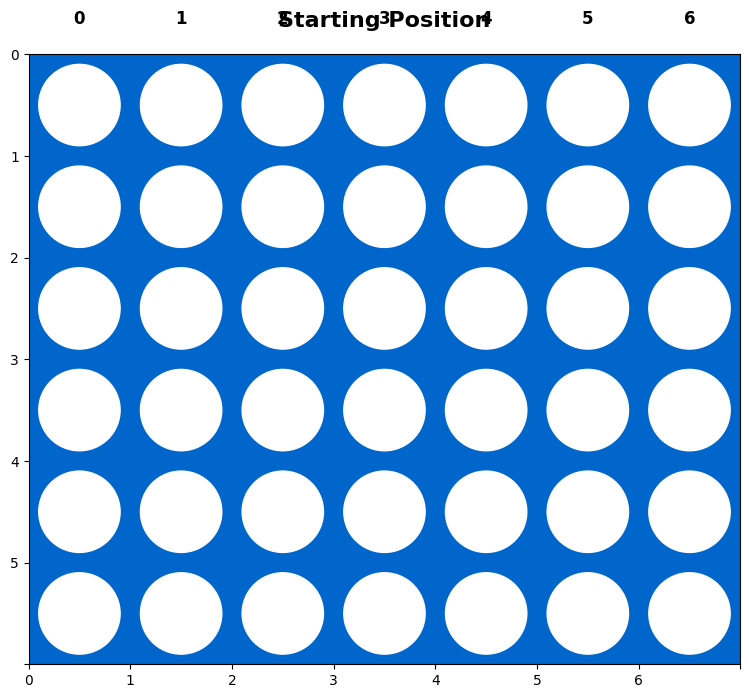


Move 1: PLAYER1 (minimax, depth=5)
  Chose column: 3
  Nodes explored: 19608
  Time: 9.4689s

  0 1 2 3 4 5 6
  --------------
0|· · · · · · · |
1|· · · · · · · |
2|· · · · · · · |
3|· · · · · · · |
4|· · · · · · · |
5|· · · R · · · |
  --------------

Move 2: PLAYER2 (alphabeta, depth=5)
  Chose column: 3
  Nodes explored: 3564
  Nodes pruned: 555
  Time: 1.3637s

  0 1 2 3 4 5 6
  --------------
0|· · · · · · · |
1|· · · · · · · |
2|· · · · · · · |
3|· · · · · · · |
4|· · · Y · · · |
5|· · · R · · · |
  --------------

Move 3: PLAYER1 (minimax, depth=5)
  Chose column: 3
  Nodes explored: 19607
  Time: 7.9415s

  0 1 2 3 4 5 6
  --------------
0|· · · · · · · |
1|· · · · · · · |
2|· · · · · · · |
3|· · · R · · · |
4|· · · Y · · · |
5|· · · R · · · |
  --------------

Move 4: PLAYER2 (alphabeta, depth=5)
  Chose column: 3
  Nodes explored: 3096
  Nodes pruned: 484
  Time: 1.8266s

  0 1 2 3 4 5 6
  --------------
0|· · · · · · · |
1|· · · · · · · |
2|· · · Y · · · |
3|· · · R · · · |

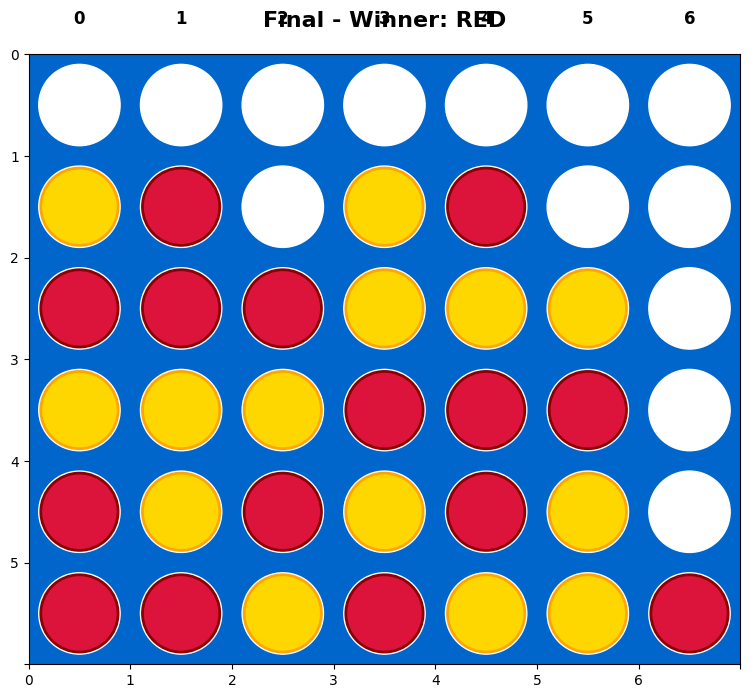


### PERFORMANCE COMPARISON ###

PERFORMANCE COMPARISON: MINIMAX vs ALPHA-BETA
Depth: 5 | Games: 3

Running games...
  Game 1: P1 wins
  Game 2: P1 wins
  Game 3: P1 wins

RESULTS

Wins: P1=3 | P2=0 | Draw=0

----------------------------------------------------------------------
Metric                         Minimax              Alpha-Beta          
----------------------------------------------------------------------
Avg Nodes per Move             14793.1              1895.2              
Avg Time per Move (ms)         6917.79              824.42              
Total Nodes                    665688               79599               
Nodes Pruned per Move          -                    366.0               
Node Reduction %               -                    87.2                
Time Reduction %               -                    88.1                
Speedup                        1.0x                 7.81                
-----------------------------------------------------------------

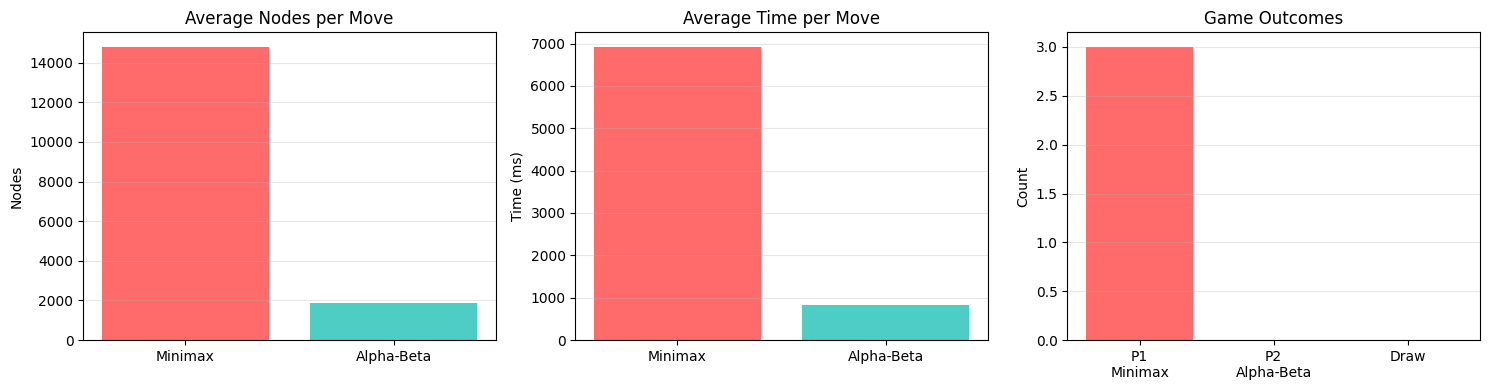


DONE ✓


In [ ]:
def detailed_performance_comparison(depth=5, num_games=3):
    print("\n" + "="*70)
    print("PERFORMANCE COMPARISON: MINIMAX vs ALPHA-BETA")
    print("="*70)
    print(f"Depth: {depth} | Games: {num_games}")

    mm_nodes = []
    mm_time = []
    ab_nodes = []
    ab_time = []
    ab_pruned = []
    winners = {'P1': 0, 'P2': 0, 'DRAW': 0}

    print("\nRunning games...")
    for i in range(num_games):
        _, metrics, winner = play_game(p1_depth=depth, p2_depth=depth,
                                      p1_algo="minimax", p2_algo="alphabeta",
                                      verbose=False, max_moves=42)

        for m in metrics['PLAYER1']:
            mm_nodes.append(m['nodes'])
            mm_time.append(m['time'])

        for m in metrics['PLAYER2']:
            ab_nodes.append(m['nodes'])
            ab_time.append(m['time'])
            ab_pruned.append(m['pruned'])

        if winner == PLAYER1:
            winners['P1'] += 1
        elif winner == PLAYER2:
            winners['P2'] += 1
        else:
            winners['DRAW'] += 1

        print(f"  Game {i+1}: {'P1 wins' if winner == PLAYER1 else 'P2 wins' if winner == PLAYER2 else 'Draw'}")

    mm_avg_nodes = np.mean(mm_nodes)
    ab_avg_nodes = np.mean(ab_nodes)
    mm_avg_time = np.mean(mm_time)
    ab_avg_time = np.mean(ab_time)
    ab_avg_pruned = np.mean(ab_pruned)

    node_reduction = (1 - ab_avg_nodes/mm_avg_nodes) * 100
    time_reduction = (1 - ab_avg_time/mm_avg_time) * 100

    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)
    print(f"\nWins: P1={winners['P1']} | P2={winners['P2']} | Draw={winners['DRAW']}")

    print("\n" + "-"*70)
    print(f"{'Metric':<30} {'Minimax':<20} {'Alpha-Beta':<20}")
    print("-"*70)
    print(f"{'Avg Nodes per Move':<30} {mm_avg_nodes:<20.1f} {ab_avg_nodes:<20.1f}")
    print(f"{'Avg Time per Move (ms)':<30} {mm_avg_time*1000:<20.2f} {ab_avg_time*1000:<20.2f}")
    print(f"{'Total Nodes':<30} {sum(mm_nodes):<20} {sum(ab_nodes):<20}")
    print(f"{'Nodes Pruned per Move':<30} {'-':<20} {ab_avg_pruned:<20.1f}")
    print(f"{'Node Reduction %':<30} {'-':<20} {node_reduction:<20.1f}")
    print(f"{'Time Reduction %':<30} {'-':<20} {time_reduction:<20.1f}")
    print(f"{'Speedup':<30} {'1.0x':<20} {mm_avg_nodes/ab_avg_nodes:<20.2f}")
    print("-"*70)

    print("\nKEY FINDINGS:")
    print(f"  • Alpha-Beta explored {node_reduction:.1f}% fewer nodes")
    print(f"  • Alpha-Beta was {time_reduction:.1f}% faster")
    print(f"  • Average {ab_avg_pruned:.0f} branches pruned per move")
    print(f"  • Both found optimal moves (same depth)")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].bar(['Minimax', 'Alpha-Beta'], [mm_avg_nodes, ab_avg_nodes],
               color=['#FF6B6B', '#4ECDC4'])
    axes[0].set_ylabel('Nodes')
    axes[0].set_title('Average Nodes per Move')
    axes[0].grid(axis='y', alpha=0.3)

    axes[1].bar(['Minimax', 'Alpha-Beta'], [mm_avg_time*1000, ab_avg_time*1000],
               color=['#FF6B6B', '#4ECDC4'])
    axes[1].set_ylabel('Time (ms)')
    axes[1].set_title('Average Time per Move')
    axes[1].grid(axis='y', alpha=0.3)

    axes[2].bar(['P1\nMinimax', 'P2\nAlpha-Beta', 'Draw'],
               [winners['P1'], winners['P2'], winners['DRAW']],
               color=['#FF6B6B', '#4ECDC4', '#95A5A6'])
    axes[2].set_ylabel('Count')
    axes[2].set_title('Game Outcomes')
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'minimax': {'avg_nodes': mm_avg_nodes, 'avg_time': mm_avg_time},
        'alphabeta': {'avg_nodes': ab_avg_nodes, 'avg_time': ab_avg_time, 'avg_pruned': ab_avg_pruned},
        'reduction': {'nodes': node_reduction, 'time': time_reduction}
    }


if __name__ == "__main__":
    print("="*70)
    print("CONNECT FOUR AI - MINIMAX vs ALPHA-BETA")
    print("="*70)

    print("\n### INITIAL BOARD ###")
    board = create_board()
    display_board(board)
    visualize_board(board, "Empty Connect Four Board")

    print("\n### SAMPLE GAME ###")
    play_game(p1_depth=5, p2_depth=5,
             p1_algo="minimax", p2_algo="alphabeta",
             verbose=True, max_moves=42)

    print("\n### PERFORMANCE COMPARISON ###")
    results = detailed_performance_comparison(depth=5, num_games=3)

    print("\n" + "="*70)
    print("DONE ✓")
    print("="*70)